# Unsupervised Segmentation Multi-Mnist dataset

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
import torch
import genus as gn
import numpy
from genus.util import linear_interpolation, append_to_dict, ckpt2file
from genus.util_ml import SpecialDataSet
from genus.util_vis import show_batch, plot_segmentation
from genus.model import CompositionalVae, instantiate_optimizer, instantiate_scheduler, process_one_epoch
from genus.namedtuple import Segmentation

### Instantiate the model, optimizer and scheduler

In [32]:
params = CompositionalVae.default_params()
vae = CompositionalVae(params=params)
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])
scheduler = instantiate_scheduler(optimizer=optimizer, 
                                  dict_params_scheduler=params["optimizer"]) if \
            params["optimizer"]["scheduler_is_active"] else None
#params
#vae

### Helper function to load dataset from npz file

In [33]:
def load_dataset_from_npz(dataset_file):
    loaded_dataset = numpy.load(dataset_file) 
    return loaded_dataset["images"], loaded_dataset["segmentations"], loaded_dataset["counts"]

### Train loader has between 0 and 3 digits

(4000, 80, 80, 1) (4000, 80, 80, 1) (4000,)


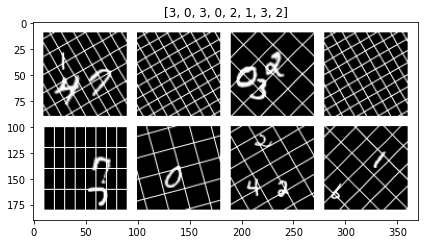

In [41]:
BATCH_SIZE=params["simulation"]["batch_size"]
dataset_file = "./example_dataset/mnist_train_80x80_n0_3_with_grid.npz"
data_imgs, data_seg, data_count = load_dataset_from_npz(dataset_file)
print(data_imgs.shape, data_seg.shape, data_count.shape)

train_loader = SpecialDataSet(x=torch.from_numpy(data_imgs).permute(0,3,1,2),
                              x_roi=None,
                              y=torch.from_numpy(data_seg).permute(0,3,1,2),
                              labels=torch.from_numpy(data_count),
                              data_augmentation=None,
                              store_in_cuda=False,
                              batch_size=BATCH_SIZE,
                              drop_last=True,
                              shuffle=True)

tmp_imgs, tmp_seg, tmp_count, index = train_loader.load(8)
title = tmp_count.tolist()
show_batch(tmp_imgs, title=str(tmp_count.tolist()))

### Test loader has between 4 and 6 digits

(3000, 80, 80, 1) (3000, 80, 80, 1) (3000,)


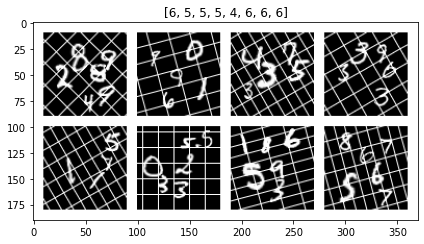

In [42]:
BATCH_SIZE=params["simulation"]["batch_size"]
dataset_file = "./example_dataset/mnist_test_80x80_n4_6_with_grid.npz"
data_imgs, data_seg, data_count = load_dataset_from_npz(dataset_file)
print(data_imgs.shape, data_seg.shape, data_count.shape)

test_loader = SpecialDataSet(x=torch.from_numpy(data_imgs).permute(0,3,1,2),
                             x_roi=None,
                             y=torch.from_numpy(data_seg).permute(0,3,1,2),
                             labels=torch.from_numpy(data_count),
                             data_augmentation=None,
                             store_in_cuda=False,
                             batch_size=BATCH_SIZE,
                             drop_last=True,
                             shuffle=True)

tmp_imgs, tmp_seg, tmp_count, index = test_loader.load(8)
title = tmp_count.tolist()
show_batch(tmp_imgs, title=str(tmp_count.tolist()))

### Training loop

In [36]:
history_dict = {}
min_test_loss = 999999

TEST_FREQUENCY = params["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = params["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = params["simulation"]["MAX_EPOCHS"]

for epoch in range(NUM_EPOCHS+1):
    vae.prob_corr_factor = linear_interpolation(epoch, 
                                                values=params["shortcut_prob_corr_factor"]["values"],
                                                times=params["shortcut_prob_corr_factor"]["times"])
    
    print(prob_corr_factor)
    
    vae.train()
    train_metrics = process_one_epoch(model=vae,
                                      dataloader=train_loader,
                                      optimizer=optimizer,
                                      scheduler=scheduler,
                                      iom_threshold=params["architecture"]["nms_threshold_train"],
                                      verbose=(epoch == 0))
    
    with torch.no_grad():
        print("Train " + train_metrics.pretty_print(epoch))
        history_dict = append_to_dict(source=train_metrics,
                                      destination=history_dict,
                                      prefix_exclude="wrong_examples",
                                      prefix_to_add="train_")
        
        if (epoch % TEST_FREQUENCY) == 0:
            vae.eval()
            test_metrics = process_one_epoch(model=vae,
                                             dataloader=test_loader,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             iom_threshold=params["architecture"]["nms_threshold_test"],
                                             verbose=(epoch == 0))
            print("Test  "+test_metrics.pretty_print(epoch))
            history_dict = append_to_dict(source=test_metrics,
                                          destination=history_dict,
                                          prefix_exclude="wrong_examples",
                                          prefix_to_add="test_")

0.4
i =   0 train_loss=72553.70312
i =   1 train_loss=72469.93750
i =   2 train_loss=72531.18750
i =   3 train_loss=72588.68750
i =   4 train_loss=72535.35156
i =   5 train_loss=72167.41406
i =   6 train_loss=70792.59375
i =   7 train_loss=59487.65625
i =   8 train_loss=56176.02344
i =   9 train_loss=53740.80859
i =  10 train_loss=54229.45703
i =  11 train_loss=58205.14844
i =  12 train_loss=58476.26172
i =  13 train_loss=58699.78125
i =  14 train_loss=59533.63672
i =  15 train_loss=58421.24219
i =  16 train_loss=57827.37109
i =  17 train_loss=57430.43359
i =  18 train_loss=55924.51562
i =  19 train_loss=55054.55078
i =  20 train_loss=53599.82031
i =  21 train_loss=52894.40625
i =  22 train_loss=51859.97266
i =  23 train_loss=52563.73047
i =  24 train_loss=52532.49219
i =  25 train_loss=52156.33594
i =  26 train_loss=51808.17969
i =  27 train_loss=52328.52734
i =  28 train_loss=52432.25781
i =  29 train_loss=53016.57422
i =  30 train_loss=52887.44531
Train [epoch    0] loss=58933.081, 

KeyboardInterrupt: 

### Save the trained model

In [37]:
ckpt_file = "./trained_model_mnist.pt"
ckpt = vae.create_ckpt(optimizer=optimizer,
                       history_dict=history_dict,
                       epoch=epoch)
ckpt2file(ckpt=ckpt, path=ckpt_file)

### Visualize the accuracy

In [38]:
# Load the trained model from file if necessary
# ckpt = file2ckpt(path=ckpt_file)
# history_dict = ckpt["history_dict"]

x_train = numpy.arange(0,len(history_dict["train_accuracy"]))
x_test = numpy.arange(0,len(history_dict["test_accuracy"])*CHECKPOINT_FREQUENCY, CHECKPOINT_FREQUENCY)
plt.plot(x_train, history_dict["train_accuracy"])
plt.plot(x_test, history_dict["test_accuracy"])

KeyError: 'test_accuracy'

### Visualize the segmentation

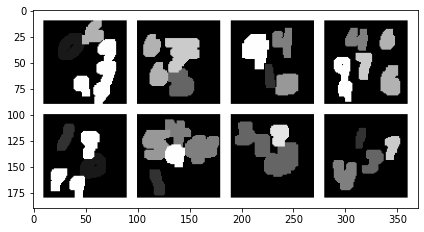

In [46]:
tmp_imgs, tmp_seg, tmp_count, index = test_loader.load(8)

show_batch(tmp_imgs)
show_batch(tmp_seg.float())

In [49]:
from genus.namedtuple import Segmentation
from genus.util_vis import plot_segmentation

In [59]:
segmentation: Segmentation = vae.segment(imgs_in=tmp_imgs,
                                         iom_threshold=params["architecture"]["nms_threshold_test"],
                                         noisy_sampling=True,
                                         draw_boxes=True,
                                         draw_boxes_ideal=True)

figures = plot_segmentation(segmentation)

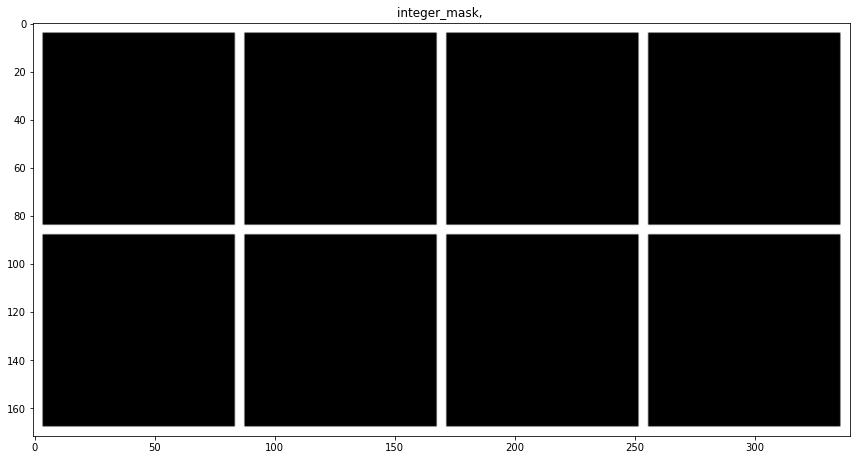

In [60]:
figures[0]

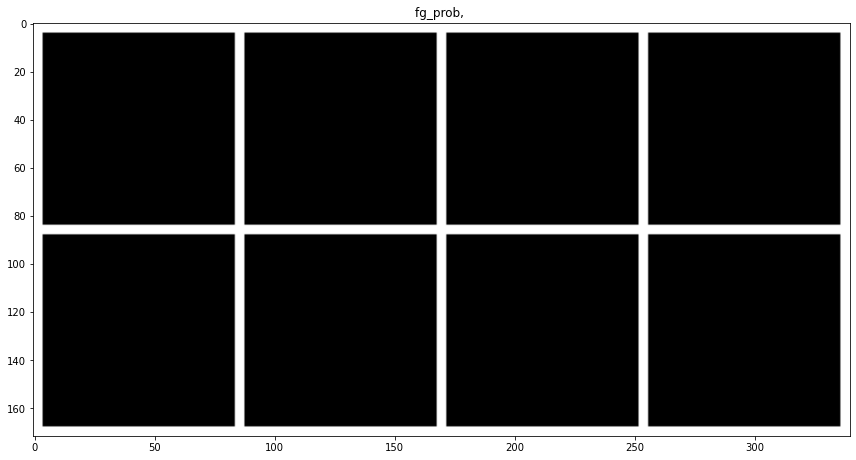

In [61]:
figures[1]